In [1]:
import csv
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import os.path
from scipy.stats import multivariate_normal
import ipywidgets as widgets
from IPython.display import display


In [2]:
def load_data(filename):
    """Load data from the csv log

    Parameters:
    filename (str)  -- the name of the csv log

    Returns:
    data (dict)     -- the logged data with data categories as keys
                       and values list of floats
    """
    is_filtered = False
    if os.path.isfile(filename + "_filtered.csv"):
        f = open(filename + "_filtered.csv")
        is_filtered = True
    else:
        f = open(filename + ".csv")

    file_reader = csv.reader(f, delimiter=',')

    # Load data into dictionary with headers as keys
    data = {}
    header = ["X", "Y", "Z", "Time Stamp", "Latitude", "Longitude",
              "Yaw", "Pitch", "Roll", "AccelX", "AccelY", "AccelZ"]
    for h in header:
        data[h] = []

    row_num = 0
    f_log = open("bad_data_log.txt", "w")
    for row in file_reader:
        for h, element in zip(header, row):
            # If got a bad value just use the previous value
            try:
                data[h].append(float(element))
            except ValueError:
                data[h].append(data[h][-1])
                f_log.write(str(row_num) + "\n")

        row_num += 1
    f.close()
    f_log.close()

    return data, is_filtered

In [3]:
def wrap_to_pi(angle):
    """Wrap angle data in radians to [-pi, pi]

    Parameters:
    angle (float)   -- unwrapped angle

    Returns:
    angle (float)   -- wrapped angle
    """
    while angle >= math.pi:
        angle -= 2*math.pi

    while angle <= -math.pi:
        angle += 2*math.pi
    return angle


In [4]:
def convert_gps_to_xy(lat_gps, lon_gps, lat_origin, lon_origin):
    """Convert gps coordinates to cartesian with equirectangular projection

    Parameters:
    lat_gps     (float)    -- latitude coordinate
    lon_gps     (float)    -- longitude coordinate
    lat_origin  (float)    -- latitude coordinate of your chosen origin
    lon_origin  (float)    -- longitude coordinate of your chosen origin

    Returns:
    x_gps (float)          -- the converted x coordinate
    y_gps (float)          -- the converted y coordinate
    """
    x_gps = EARTH_RADIUS*(math.pi/180.)*(lon_gps - lon_origin)*math.cos((math.pi/180.)*lat_origin)
    y_gps = EARTH_RADIUS*(math.pi/180.)*(lat_gps - lat_origin)

    return x_gps, y_gps


In [5]:
data17, _ = load_data("2020_2_26__17_21_59_filtered")

In [6]:
#accleration covariance calculations
#assuming uncorrelated Accelx, accelY
var_accX = np.var(data17["AccelX"][669:])
var_accY = np.var(data17["AccelY"][669:])
covar_u_t = np.array([[var_accX, 0],
                      [0, var_accY]])
print(var_accX, var_accY)

0.2597510387811634 0.14175408587257618


In [7]:
HEIGHT_THRESHOLD = 0.0  # meters
GROUND_HEIGHT_THRESHOLD = -.4  # meters
DT = 0.1
X_LANDMARK = 5.  # meters
Y_LANDMARK = -5.  # meters
EARTH_RADIUS = 6.3781E6  # meters

In [8]:
yaw_corrected = np.zeros(len(data17["Yaw"][669:]))
yaw_data = data17["Yaw"][669:]

for i in range(len(data17["Yaw"][669:])):
    
    yaw_corrected[i] = wrap_to_pi(yaw_data[i]*(np.pi/180))

yaw_corrected

array([ 0.01090831,  0.        ,  0.00109083, -0.00436332,  0.        ,
       -0.00109083,  0.00872665,  0.00436332,  0.00654498,  0.00545415,
        0.00654498,  0.00654498,  0.00763582,  0.00654498,  0.00654498,
        0.00654498,  0.00654498,  0.00545415,  0.00545415,  0.00545415,
        0.00545415,  0.00545415,  0.00654498,  0.00654498,  0.00654498,
        0.00654498,  0.00763582,  0.00763582,  0.00763582,  0.00763582,
        0.00763582,  0.00763582,  0.00763582,  0.00763582,  0.00763582,
        0.00763582,  0.00763582,  0.00763582])

In [9]:
#calculating sensor covariance matrix. We assume that all measurements are independent, and that the covariance is equal
#to the stationary variance
#recall: measurement vector is Zx, Zy, yaw
var_Zx = np.var(data17["X"][669:])
var_Zy = np.var(data17["Y"][669:])
var_yaw = np.var(yaw_corrected)
# covar_z = np.array([[var_Zx, 0, 0],
#                     [ 0, var_Zy, 0],
#                     [0, 0, var_yaw]])

covar_z = np.array([[0.1, 0, 0],
                    [ 0, .1, 0],
                    [0, 0, var_yaw]])
print(var_Zx, var_Zy, var_yaw)

0.0001698159186405823 0.0004478908815990326 8.613675903064495e-06


In [10]:
def propogate_state(x_t_prev, u_t):
    """Propogate/predict the state based on chosen motion model

    Parameters:
    x_t_prev (np.array)  -- the previous state estimate
    u_t (np.array)       -- the current control input

    Returns:
    x_bar_t (np.array)   -- the predicted state
    """
    """STUDENT CODE START"""
    #Xt = [xg, yg, yaw, yaw_t-1, Vx, Vy, omega]'
    angle_correction = x_t_prev[2]
    #angle_correction = wrap_to_pi(x_t_prev[2])

    A_matrix = np.array([[1, 0, 0, 0, DT, 0, 0],
                         [0, 1, 0, 0, 0, DT, 0],
                         [0, 0, 1, 0, 0, 0, DT],
                         [0, 0, 1, 0, 0, 0, 0 ],
                         [0, 0, 0, 0, 1, 0, 0 ],
                         [0, 0, 0, 0, 0, 1, 0 ],
                         [0, 0, 1/DT, -1/DT, 0, 0, 0]])
    
    #angle_correction = wrap_to_pi(2*np.pi - x_t_prev[2])
    
    
    #angle_correction = wrap_to_pi(-x_t_prev[2])
    
    #adding perturbation into the yaw, as u_t has no bearing on it
    mean_yaw = 0
    stdev_yaw = 0.5*np.pi/180
    
    random_delta_yaw = np.random.normal(loc = mean_yaw, scale = stdev_yaw)
    
    
    

    #no holonomic motion assumption

    B_matrix = np.array([[1/2*np.square(DT)*np.cos(angle_correction), 0],
                     [-1/2*np.square(DT)*np.sin(angle_correction), 0],
                     [0, 0],
                     [0, 0],
                     [DT*np.cos(angle_correction), 0], 
                     [-DT*np.sin(angle_correction), 0],
                     [0, 0]])
    
#     B_matrix = np.array([[1/2*np.square(DT)*np.cos(angle_correction), 1/2*np.square(DT)*np.sin(angle_correction)],
#                      [-1/2*np.square(DT)*np.sin(angle_correction), 1/2*np.square(DT)*np.cos(angle_correction)],
#                      [0, 0],
#                      [0, 0],
#                      [DT*np.cos(angle_correction), DT*np.sin(angle_correction)], 
#                      [-DT*np.sin(angle_correction), DT*np.cos(angle_correction)],
#                      [0, 0]])

    x_bar_t = A_matrix@x_t_prev + B_matrix@u_t
    x_bar_t[2] = wrap_to_pi((A_matrix@x_t_prev)[2] + (B_matrix@u_t)[2] + random_delta_yaw)
    x_bar_t[3] = wrap_to_pi((A_matrix@x_t_prev)[3] + (B_matrix@u_t)[3])
    
    
    x_bar_t[6] = wrap_to_pi(x_t_prev[2] - x_t_prev[3]) / DT
    #x_bar_t[6] = (wrap_to_pi(x_t_prev[2]) - wrap_to_pi(x_t_prev[3])) / DT
    #x_bar_t[2] = wrap_to_pi(x_bar_t[2])

    """STUDENT CODE END"""

    return x_bar_t

In [11]:
def propogate_state2(x_t_prev, u_t):
    """
    propogate the state using random forward motion
    
    Assumes no slide slipping
    """
    
# #     #based on time to travel on side in experiment. assuming constant velocity, m/s
#     mean_speed = 0.5*DT*u_t[0]
#     stdev_speed = np.abs(mean_speed/2) #arbitrary, picked to ensure 0 m/s possible

#     random_velocity = np.random.normal(loc = mean_speed, scale = stdev_speed)

    mean_motion = 0.07
    std_motion = 0.06
    random_forward = np.random.normal(loc = mean_motion, scale = std_motion)

    mean_yaw = 0
    stdev_yaw = 0.05#5*np.pi/180
    
    random_delta_yaw = np.random.normal(loc = mean_yaw, scale = stdev_yaw)
    
    curr_yaw = wrap_to_pi(x_t_prev[2] + random_delta_yaw)
    
#     rot = np.array([[np.cos(curr_yaw), np.sin(curr_yaw)],
#                     [-np.sin(curr_yaw), np.cos(curr_yaw)]])

    rot = np.array([[np.cos(curr_yaw), 0],
                    [-np.sin(curr_yaw), 0]])
    
#     global_velocities = rot @ np.array([random_velocity, 0])

    forward_motion = rot @ np.array([random_forward, 0])
    
    x_t = np.zeros((3,1))
    x_t[0] = x_t_prev[0] + forward_motion[0]
    x_t[1] = x_t_prev[1] + forward_motion[1]
    x_t[2] = curr_yaw
    
    x_t = x_t.flatten()
    
    return x_t    

## State Representation

### At each time step, the ith row of the particle matrix has the states corresponding to the ith particle 

In [12]:
def getWeight(x_t, z_t, covar_z_t):
    
    estimated = x_t[0:3]
    
#     print("estimated measurement ", estimated)
#     print("actual measurement ", z_t, "\n")
    
    
    weight = multivariate_normal.pdf(z_t, mean=estimated, cov=covar_z_t)
    
#     if weight == 0:
#         print("getWeight")
#         print('x_t')
#         print(x_t)
#         print('estimated')
#         print(estimated)
#         print('z_t')
#         print(z_t)
#         print('weight')
#         print(weight)
#         print("wtf")
    
    return weight
    

In [13]:
def prediction_step(x_t_prev, u_t, covar_u_t, z_t, covar_z_t):
    '''
    z_t is the bot's position in the global frame
    
    '''
    
    x_t_bar = np.zeros(x_t_prev.shape)
    weights = np.zeros(len(x_t_prev))
    
    for i in range(len(x_t_prev)):
        perturbed_u_t = np.zeros(2)
        
        # Get previous state
        prev_state = x_t_prev[i]
        
        # Perturb control input
        perturbed_u_t[0] = u_t[0] + np.random.normal(loc = 0, scale = np.sqrt(covar_u_t[0][0]))
        perturbed_u_t[1] = u_t[1] + np.random.normal(loc = 0, scale = np.sqrt(covar_u_t[1][1]))
        
        # Get new state using perturbed control input
        new_state = propogate_state2(prev_state, perturbed_u_t)
        new_weight = getWeight(new_state, z_t, covar_z_t)

        
        # Store
        x_t_bar[i] = new_state
        weights[i] = new_weight
        
    #print(np.sum(weights))
        
#     if np.isnan(np.sum(weights)):
#         print("")
#         print(x_t_prev)
#         print(z_t)
#         print(weights)
#         print('')
    epsilon = 1e-12
    weights_sum = weights/(np.sum(weights))
    
    
#     if np.isnan(np.sum(weights_sum)):
#         print(x_t_prev)
#         print(z_t)
#         print(weights)
#         print(np.sum(weights))
    #print(np.sum(weights))
    
    
#     for i in range(len(x_t_prev)):
        
#         print("Particle # is: ", i)
#         print("Prev state is: ", x_t_prev[i])
#         print("propogated State is: ", x_t_bar[i])
#         print("Weight is: ", weights_sum[i])
#         print("current Max is: ", np.max(weights_sum[0:i+1]))
#         print()
        
    return x_t_bar, weights_sum
        
    

In [14]:
def correction_step(x_bar_t, weights):
    
    x_t = np.zeros(x_bar_t.shape)
    #weights = np.zeros(len(x_bar_t))
        
    x_ind = np.arange(len(x_bar_t))
    
    for i in range(len(x_bar_t)):
        
        #print(x_ind.shape)
        #print(weights.shape)
        #print("correction")
        #print(np.sum(weights))
        
#         if np.isnan(np.sum(weights)):
#             print(weights)
        x_t_index = np.random.choice(a = x_ind, p = weights)
        
        x_t[i] = x_bar_t[x_t_index]
        #weights[i] = weights[x_t_index]
        
        #print("resampled particle: ", x_t_index)
        
    return x_t
        

In [15]:
def initializeParticles(numParticles, numStates):
    
    states = np.zeros([numParticles, numStates])
    
    #x: 0.157586
    #y: -0.145739
    
    x_col = np.random.normal(loc = 0, scale = 0.25, size = numParticles)
    y_col = np.random.normal(loc = 0, scale = 0.25, size = numParticles)
    
    yaw_col = np.random.normal(loc = 0, scale = 0.01, size = numParticles)
    #yaw_col = np.where(yaw_col < 0, yaw_col + np.pi*2, yaw_col)
    
     
    
    states[:, 0] = x_col
    states[:, 1] = y_col
    states[:, 2] = yaw_col
    states[:, 3] = yaw_col
        
    return states
    
    

In [16]:
def initializeParticles2(numParticles, numStates):
    
    """
    initialize for only x, y, and theta
    """
    
    states = np.zeros([numParticles, numStates])
    
    x_col = np.random.normal(loc = 0.157586, scale = 0.25, size = numParticles)
    y_col = np.random.normal(loc = -0.145739, scale = 0.25, size = numParticles)
    
    yaw_col = np.random.normal(loc = 0, scale = 0.01, size = numParticles)
    #yaw_col = np.where(yaw_col < 0, yaw_col + np.pi*2, yaw_col)
    
    states[:, 0] = x_col
    states[:, 1] = y_col
    states[:, 2] = yaw_col
    
    return states

In [17]:
def initializeParticles3(numParticles, numStates):
    
    """
    """
    
    states = np.zeros([numParticles, numStates])
    
    x_lower = -1
    x_upper = 11
    y_lower = -11
    y_upper = 1
    yaw_lower = -np.pi
    yaw_upper = np.pi
    
    x_col = np.random.uniform(low = x_lower, high = x_upper, size = numParticles)
    y_col = np.random.uniform(low = y_lower, high = y_upper, size = numParticles)
    yaw_col = np.random.uniform(low = yaw_lower, high = yaw_upper, size = numParticles)
    
    states[:, 0] = x_col
    states[:, 1] = y_col
    states[:, 2] = yaw_col
    
    return states
    
    

In [42]:
states = initializeParticles3(1000, 3)

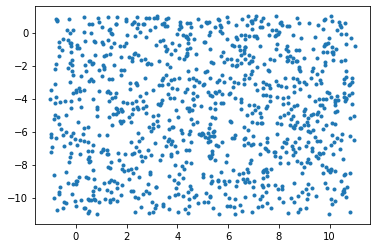

In [44]:
plt.plot(states[:, 0], states[:, 1], ".")

In [18]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [45]:
def main():
    
    filename = '2020_2_26__17_21_59_filtered'
    data, is_filtered = load_data(filename)
    
    # Load data into variables
    x_lidar = data["X"]
#     x_lidar = running_mean(x_lidar, 10)
    y_lidar = data["Y"]
#     y_lidar = running_mean(y_lidar, 10)
    z_lidar = data["Z"]
    time_stamps = data["Time Stamp"]
    lat_gps = data["Latitude"]
    lon_gps = data["Longitude"]
    yaw_lidar = data["Yaw"]
#     yaw_lidar = running_mean(yaw_lidar, 10)
    pitch_lidar = data["Pitch"]
    roll_lidar = data["Roll"]
    x_ddot = data["AccelX"]
    y_ddot = data["AccelY"]
    
    lat_origin = lat_gps[0]
    lon_origin = lon_gps[0]
    
    # Initialize filter
    numParticles = 1000
    numStates = 3
#     x_t_prev = initializeParticles(numParticles, numStates) #7 element state
    x_t_prev = initializeParticles3(numParticles, numStates) #3 element state
    
    # Store particles and gps
    particles = np.empty((numParticles, numStates, len(time_stamps)))
    vis_particles = np.empty((len(time_stamps), 2, numParticles))
    gps_estimates = np.empty((2, len(time_stamps)))
    weights_out = np.zeros((numParticles, len(time_stamps)))
    z_t_out = np.zeros((3, len(time_stamps)))
    
    converted_yaws = np.zeros(len(time_stamps))
#     z_ts = np.zeros((3, len(time_stamps)-10))
#     for t, _ in enumerate(time_stamps[0:-10]):
#         converted_yaws[t] = wrap_to_pi(yaw_lidar[t] * np.pi / 180)

#         z_ts[:, t] = np.array([5 - (x_lidar[t]*(-np.sin(converted_yaws[t])) + y_lidar[t]*(np.cos(converted_yaws[t]))),
#                             -5 - (x_lidar[t]*(-np.cos(converted_yaws[t])) - y_lidar[t]*(np.sin(converted_yaws[t]))),
#                             converted_yaws[t]])
        
#     z_ts[0, :] = running_mean(z_ts[0, :], 10)
#     z_ts[1, :] = running_mean(z_ts[1, :], 10)
#     z_ts[2, :] = running_mean(z_ts[2, :], 10)

    
    for t, _ in enumerate(time_stamps):
        #print(t)
        
#         print("timestep = ", t)
#         print("previous x = ", x_t_prev)
        
        u_t = np.array([x_ddot[t], y_ddot[t]])
        
        #converted_yaw = converted_yaws[t]
        #z_t = z_ts[:, t]
        
        converted_yaw = wrap_to_pi(yaw_lidar[t] * np.pi / 180)
        
        z_t = np.array([5 - (x_lidar[t]*(-np.sin(converted_yaw)) + y_lidar[t]*(np.cos(converted_yaw))),
                        -5 - (x_lidar[t]*(-np.cos(converted_yaw)) - y_lidar[t]*(np.sin(converted_yaw))),
                        converted_yaw])
        
        # Prediction Step
#         print("time stamp: ", t)
        x_bar_t, weights = prediction_step(x_t_prev, u_t, covar_u_t, z_t, covar_z)
        #print(np.sum(weights))
#         print("predicted x = ", x_bar_t)
#         print()
        
        # Correction Step
#         x_t = correction_step(x_bar_t, weights)
        
        try:
            x_t = correction_step(x_bar_t, weights)
            
        except:
            print("Something went wrong at t=", t)
            particles[:, :, t] = x_t
            weights_out[:, t] = weights
            return particles, vis_particles, gps_estimates, t, weights_out, z_t_out
        
        
        # Explicitly set x_t_prev to x_t
        x_t_prev = x_t
        
        # Store shit
        particles[:, :, t] = x_t
        
        vis_particles[t,0] = particles[:, 0, t].flatten()
        vis_particles[t,1] = particles[:, 1, t].flatten()

        x_gps, y_gps = convert_gps_to_xy(lat_gps=lat_gps[t],
                                         lon_gps=lon_gps[t],
                                         lat_origin=lat_origin,
                                         lon_origin=lon_origin)
        
        gps_estimates[:, t] = np.array([x_gps, y_gps])
        
        weights_out[:, t] = weights
        
        z_t_out[:, t] = z_t
               
    return particles, vis_particles, gps_estimates, t, weights_out, z_t_out
    

In [46]:
P_t, particles, gps_estimates, lastIdx, weights, z_t = main()



In [47]:
print(lastIdx)
P_t = P_t[:, :, 0:lastIdx]
weights = weights[:, 0:lastIdx]
z_t = z_t[:, 0:lastIdx]

706


<IPython.core.display.Javascript object>


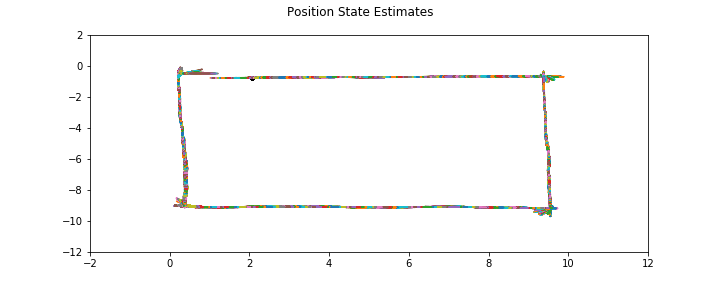

interactive(children=(IntSlider(value=0, description='Time Step', max=705), Output()), _dom_classes=('widget-i…

In [55]:
%matplotlib notebook
%matplotlib nbagg
### Plot X, Y particles states w/ slider
particles_to_plot = P_t
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('Position State Estimates')

minTimeStep = 0
maxTimeStep = particles_to_plot.shape[2]


# def update_plot(time_pos):
    
#     ax.clear()
#     x_positions = particles_to_plot[:, 0, time_pos]
#     y_positions = particles_to_plot[:, 1, time_pos]
#     ax.plot(x_positions, y_positions, "k.")
#     ax.set_xlim((-2, 12))
#     ax.set_ylim((-12, 2))
    
    
# #     y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
# #     units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
# #     ax.plot(x, y, label=units.format(amp, phase, freq))
# #     ax.set_xlim(x[0], x[-1])
# #     ax.legend(loc=1)
# #     ax.set_xlabel('$(s)$')
#     plt.show()


# # amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
# # phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
# time_pos = widgets.IntSlider(min=minTimeStep, max=maxTimeStep-1, value=0, description='Time Step')
    
# widgets.interactive(update_plot, time_pos=time_pos)
# ### Plot X, Y particles states w/ slider
# particles_to_plot = P_t
# fig, ax = plt.subplots(1, figsize=(10, 4))
# plt.suptitle('Position State Estimates')

# minTimeStep = 0
# maxTimeStep = particles_to_plot.shape[2]


def update_plot(time_pos):
    
    ax.clear()
    x_positions = particles_to_plot[:, 0, time_pos]
    y_positions = particles_to_plot[:, 1, time_pos]
    ax.plot(x_positions, y_positions, "k.")
    ax.set_xlim((-2, 12))
    ax.set_ylim((-12, 2))
    
    
#     y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
#     units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
#     ax.plot(x, y, label=units.format(amp, phase, freq))
#     ax.set_xlim(x[0], x[-1])
#     ax.legend(loc=1)
#     ax.set_xlabel('$(s)$')
    plt.show()


# amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
# phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
time_pos = widgets.IntSlider(min=minTimeStep, max=maxTimeStep-1, value=0, description='Time Step')
    
widgets.interactive(update_plot, time_pos=time_pos)

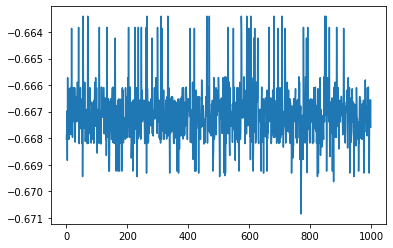

In [23]:
%matplotlib inline
plt.plot(P_t[:, 1, -1])

In [24]:
P_t_x = []
P_t_y = []

for i in range(706):
    
    P_t_x.append(np.mean(P_t[:,0,i]))
    P_t_y.append(np.mean(P_t[:,1,i]))
    

#P_t = P_t[:, :, 0:lastIdx]


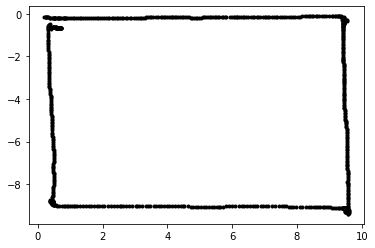

In [25]:
plt.plot(P_t_x, P_t_y, 'k.')

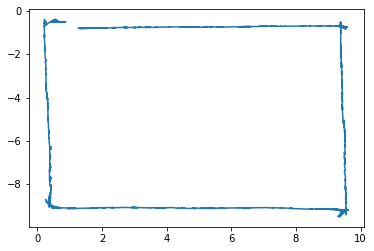

In [76]:
#plotting the particle with the max weight
%matplotlib inline
best_est = np.argmax(weights, axis = 0)

x_points = []
y_points = []

for i in range(len(best_est)):
    x_points.append(P_t[best_est[i], 0, i])
    y_points.append(P_t[best_est[i], 1, i])
    
plt.plot(x_points, y_points)


<IPython.core.display.Javascript object>


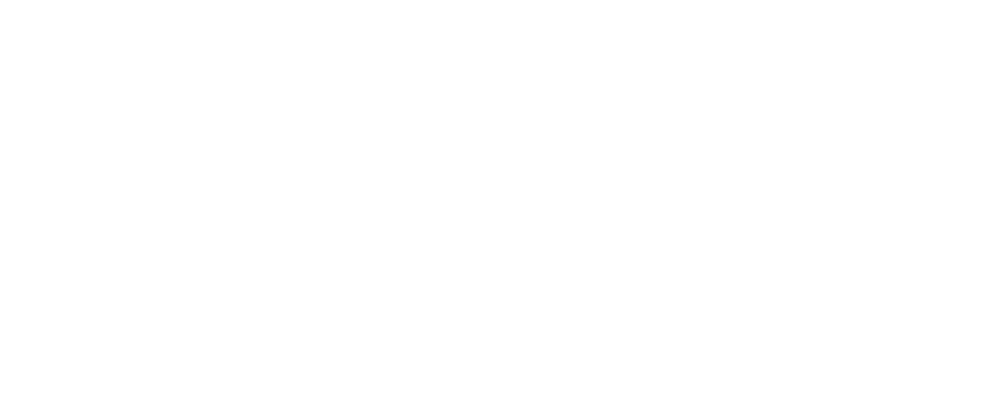

interactive(children=(IntSlider(value=0, description='Time Step', max=705), Output()), _dom_classes=('widget-i…

In [28]:
### Plot yaw w/ slider
%matplotlib notebook

particles_to_plot = P_t
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('State Estimate')

minTimeStep = 0
maxTimeStep = particles_to_plot.shape[2]


def update_plot_yaw(time_yaw):
    
    ax.clear()
    yaw = particles_to_plot[:, 2, time_yaw]
    times = np.ones(yaw.size)*time_yaw
    ax.plot(times, yaw, "kx")
#     ax.set_xlim((-2, 12))
#     ax.set_ylim((-0.35, 0.15))
    
    
#     y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
#     units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
#     ax.plot(x, y, label=units.format(amp, phase, freq))
#     ax.set_xlim(x[0], x[-1])
#     ax.legend(loc=1)
#     ax.set_xlabel('$(s)$')
    plt.show()


# amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
# phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
time_yaw = widgets.IntSlider(min=minTimeStep, max=maxTimeStep-1, value=0, description='Time Step')
    
widgets.interactive(update_plot_yaw, time_yaw=time_yaw)

In [29]:
weights.shape

(1000, 706)

<IPython.core.display.Javascript object>


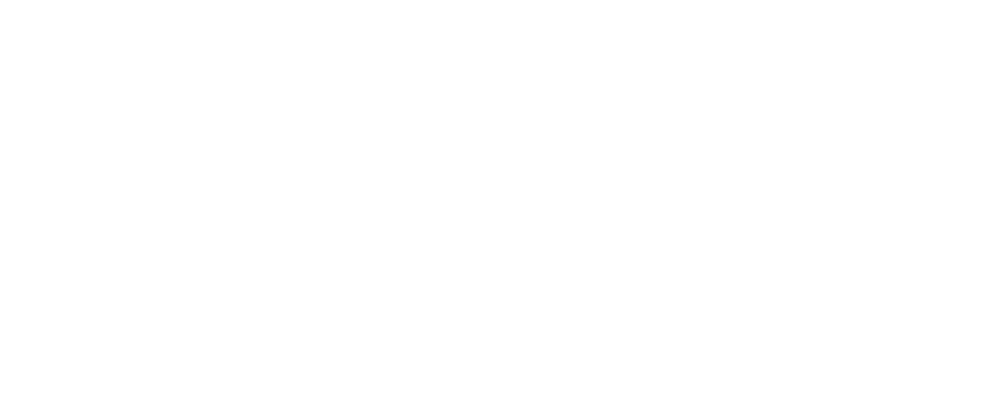

interactive(children=(IntSlider(value=0, description='Time Step', max=705), Output()), _dom_classes=('widget-i…

In [30]:
### Plot yaw w/ slider
%matplotlib notebook

weight_to_plot = weights
fig, ax = plt.subplots(1, figsize=(10, 4))
plt.suptitle('Weights')

minTimeStep = 0
maxTimeStep = weight_to_plot.shape[1]


def update_plot_weight(time_weight):
    
    ax.clear()
    weight = weight_to_plot[:, time_weight]
    times = np.ones(weight.size)*time_weight
    ax.plot(times, weight, "kx")
#     ax.set_xlim((-2, 12))
#     ax.set_ylim((-0.35, 0.15))
    
    
#     y = amp * np.sin(freq * 2 * np.pi * x + phase * 2 * np.pi)
#     units = 'amp = {} $(psi)$ \nphase = {} $(s)$ \nfreq = {} $(Hz)$'
    
#     ax.plot(x, y, label=units.format(amp, phase, freq))
#     ax.set_xlim(x[0], x[-1])
#     ax.legend(loc=1)
#     ax.set_xlabel('$(s)$')
    plt.show()


# amp = widgets.FloatSlider(min=1, max=10, value=1, description='Amp:')
# phase = widgets.FloatSlider(min=0, max=5, value=0, description='Phase:')
time_weight = widgets.IntSlider(min=minTimeStep, max=maxTimeStep-1, value=0, description='Time Step')
    
widgets.interactive(update_plot_weight, time_weight=time_weight)

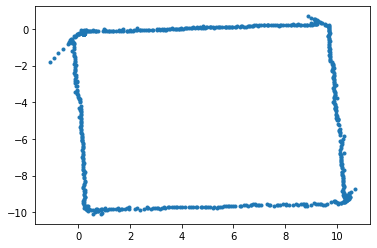

In [31]:
%matplotlib inline
plt.plot(z_t[0], z_t[1], ".")
# plt.xlim((8, 10))
# plt.ylim((-1, 1))

In [32]:
ts = -41
print("z_t is ", z_t[:, ts])
print()
x = np.unique(P_t[:, :, ts], axis = 0)
print(x)

z_t is  [ 0.0771935  -0.22154854 -0.00545415]

[[ 4.02530475e-01 -6.75541445e-01 -1.04537131e-02]
 [ 4.23098977e-01 -6.62454384e-01 -1.27830110e-02]
 [ 4.45386343e-01 -6.67607196e-01 -2.12752570e-03]
 [ 4.46181000e-01 -6.67523551e-01 -4.26209645e-03]
 [ 4.56473485e-01 -6.67499521e-01 -7.39150678e-03]
 [ 4.59959761e-01 -6.67392064e-01 -1.15889415e-02]
 [ 4.66833767e-01 -6.67161942e-01  7.61037833e-04]
 [ 4.82227079e-01 -6.67076860e-01 -1.29580456e-02]
 [ 4.89578221e-01 -6.67470339e-01 -4.71041974e-04]
 [ 4.93474299e-01 -6.73723771e-01 -9.60723743e-03]
 [ 4.93589563e-01 -6.66988337e-01 -1.28556521e-02]
 [ 4.93814502e-01 -6.66898235e-01 -8.27012548e-03]
 [ 4.97476181e-01 -6.65546267e-01 -4.58409790e-04]
 [ 5.04092529e-01 -6.61812080e-01 -6.48194538e-03]
 [ 5.06009984e-01 -6.73305062e-01 -5.12542112e-03]
 [ 5.15035179e-01 -6.66407754e-01 -1.42469544e-02]
 [ 5.15638496e-01 -6.69533304e-01 -3.48350455e-03]
 [ 5.21358106e-01 -6.65504274e-01 -6.69691885e-03]
 [ 5.24980633e-01 -6.66333712e-01 -

In [33]:
ts = -39
print("z_t is ", z_t[:, ts])
print()
x = np.unique(P_t[:, :, ts], axis = 0)
print(x)

z_t is  [ 0.15945301 -0.22031917  0.03817908]

[[ 0.48304615 -0.67835054  0.03527057]
 [ 0.48418759 -0.66708123  0.04533142]
 [ 0.48437891 -0.66715099  0.04322475]
 [ 0.48903782 -0.6795127   0.04644748]
 [ 0.49758485 -0.66786867  0.03244859]
 [ 0.50605109 -0.67873137  0.03104803]
 [ 0.50725836 -0.6789296   0.03260481]
 [ 0.51517562 -0.67094788  0.03610562]
 [ 0.51725508 -0.67927089  0.03273925]
 [ 0.52844148 -0.6690609   0.04349771]
 [ 0.54170797 -0.6727747   0.04162983]
 [ 0.54576728 -0.66612413  0.0294325 ]
 [ 0.54795076 -0.66672685  0.03573757]
 [ 0.54814916 -0.66718876  0.03124446]
 [ 0.55215938 -0.66667474  0.03083545]
 [ 0.56705642 -0.67548218  0.03076709]
 [ 0.56752123 -0.67338518  0.03702966]
 [ 0.57463232 -0.66892717  0.04370093]
 [ 0.58525027 -0.66883122  0.0459284 ]
 [ 0.58856429 -0.66422295  0.03233462]
 [ 0.60078972 -0.66405721  0.03534172]
 [ 0.60280212 -0.67732683  0.04063047]
 [ 0.60358473 -0.67424279  0.02953022]
 [ 0.6054934  -0.66494545  0.04056473]
 [ 0.60618032 -0.

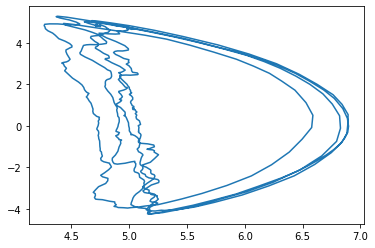

In [34]:
%matplotlib inline

yaw_wrapped = np.zeros(len(data17["Yaw"]))
yaw_data = data17["Yaw"]

x_lidar = data17["X"]
x_lidar = running_mean(x_lidar, 3)
y_lidar = data17["Y"]
y_lidar = running_mean(y_lidar, 3)
yaw_lidar = data17["Yaw"]
yaw_lidar = running_mean(yaw_lidar, 3)

for i in range(len(data17["Yaw"])):
    
    yaw_wrapped[i] = wrap_to_pi(yaw_data[i]*(np.pi/180))

yaw_wrapped

plt.plot(x_lidar, y_lidar)

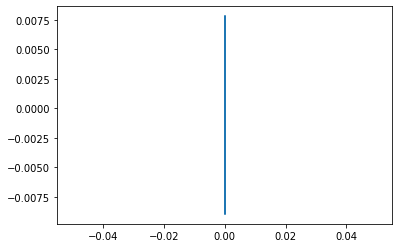

In [35]:
%matplotlib inline

plt.plot(np.ones(P_t[:, 2, 170].shape)*0, P_t[:, 2, 0])


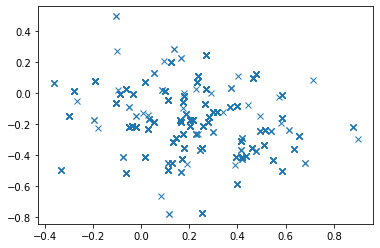

In [36]:
%matplotlib inline
plt.plot(P_t[:, 0, 0], P_t[:, 1, 0], "x")
plt.show()

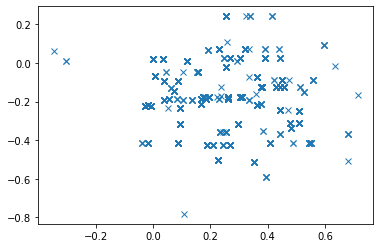

In [37]:
%matplotlib inline
plt.plot(P_t[:, 0, 1], P_t[:, 1, 1], "x")
plt.show()

In [39]:
%matplotlib inline
test = np.ones(1000)/1000

In [40]:
np.random.choice(a = np.arange(1000), p = test)

949